# Homework 03: K-means and Principle Component Analysis

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import numpy as np
import pandas as pd
import os.path
import subprocess
from sklearn import cluster, decomposition

# github save check

Helpers for Getting, Loading and Locating Data

In [2]:
def wget_data(url: str):
    local_path = './tmp_data'
    p = subprocess.Popen(["wget", "-nc", "-P", local_path, url], stderr=subprocess.PIPE, encoding='UTF-8')
    rc = None
    while rc is None:
      line = p.stderr.readline().strip('\n')
      if len(line) > 0:
        print(line)
      rc = p.poll()

def locate_data(name, check_exists=True):
    local_path='./tmp_data'
    path = os.path.join(local_path, name)
    if check_exists and not os.path.exists(path):
        raise RuxntimeError('No such data file: {}'.format(path))
    return path

## <span style="color:Orange">Problem 1</span>

In [3]:
from sklearn import cluster, decomposition

In [4]:
wget_data('https://raw.githubusercontent.com/illinois-ipaml/MachineLearningForPhysics/main/data/spectra_data.hf5')

--2025-09-16 17:33:22--  https://raw.githubusercontent.com/illinois-ipaml/MachineLearningForPhysics/main/data/spectra_data.hf5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 414744 (405K) [application/octet-stream]
Saving to: ‘./tmp_data/spectra_data.hf5’
     0K .......... .......... .......... .......... .......... 12%  835K 0s
    50K .......... .......... .......... .......... .......... 24%  873K 0s
   100K .......... .......... .......... .......... .......... 37% 3.80M 0s
   150K .......... .......... .......... .......... .......... 49% 1.43M 0s
   200K .......... .......... .......... .......... .......... 61% 5.67M 0s
   250K .......... .......... .......... .......... .......... 74% 6.55M 0s
   300K .......... .......... .......... .......... ...

In [5]:
spectra_data = pd.read_hdf(locate_data('spectra_data.hf5'))

The PCA method of dimensionality reduction first calculates an exact linear decomposition (up to round off error),
then trims rows and columns to the desired number of latent variables.  In this problem, you will explore how PCA is implemented. The tricky linear algebra is already implemented in [numpy.linalg](https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.linalg.html), but it is still a challenge to keep all the notation and conventions self consistent.

The input data $X$ is provided as an $N\times D$ (samples, features) matrix. In the following we assume that each feature is centered on zero (otherwise, calculate and subtract the $\mu_j$, then add them back later),

$$ \Large
\mu_j = \sum_i X_{ij} = 0 \;.
$$

There are three equivalent methods for performing the initial exact decomposition:

1. Calculate the $D\times D$ [sample covariance matrix](https://en.wikipedia.org/wiki/Sample_mean_and_covariance#Sample_covariance)

$$ \Large
C \equiv \frac{1}{N-1}\,X^T X \;.
$$

then find its eigenvalue decomposition:

$$ \large
C = Q^T \Lambda Q
$$

where $\Lambda$ is a diagonal $D\times D$ matrix of eigenvalues and the rows of the orthogonal $D\times D$ matrix $Q$ are the corresponding eigenvectors.

2. Calculate the $N\times N$ matrix of dot products between samples:

$$ \Large
D \equiv \frac{1}{N-1}\,X X^T \;,
$$

then find its eigenvalue decomposition, where now $Q$ and $\Lambda$ are $N\times N$ matrices.

3. Find the [singular value decomposition (SVD)](https://en.wikipedia.org/wiki/Singular-value_decomposition) of $X$

$$ \Large
X = U S V \quad \Rightarrow \quad C = \frac{1}{N-1}\,V^T S^2 V \;,
$$

where $S$ is a diagonal $K\times K$ matrix of *singular values*, $U$ is $N\times K$ and $V$ is $K\times D$, with
$K = \min(N, D)$. The notation above is chosen to match [np.linalg.svd](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.linalg.svd.html) which you will use below.

The computational cost of each method depends differently on the values of $N$ and $D$, so the most efficient method will depend on the shape of the input data $X$. There are also numerical considerations: the matrices $C$ and $D$ should be [positive definite](https://en.wikipedia.org/wiki/Positive-definite_matrix) in order to guarantee positive eigenvalues, but this will not be true for $C$ if $N < D$ or for $D$ if $N > D$.

Implement the function below to calculate the eigenvectors and eigenvalues of a square input matrix using a suitable function from [np.linalg](https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.linalg.html).  The results should be sorted in order of decreasing eigenvalues, as needed by PCA. Hint: `M[::-1]` reverses the rows of a 2D array `M` (more info [here](https://docs.scipy.org/doc/numpy-dev/user/quickstart.html#indexing-slicing-and-iterating)).

In [22]:
def eigensolve(M):
    """Calculate eigenvectors and eigenvalues of a square symmetric matrix.

    Results are sorted by decreasing eigenvalue. The rows (not columns) of the
    returned eigenvector array are the normalized eigenvectors of M.

    Parameters
    ----------
    M : 2D array
        N x N symmetric square matrix to use.

    Returns
    -------
    tuple
        Tuple of arrays (eigenvalues, eigenvectors) with eigenvalues decreasing and
        eigenvector[i] corresponding to eigenvalue[i].  Eigenvalues should have the
        shape (N,) and eigenvectors should have the shape (N, N).
    """
    assert len(M.shape) == 2
    nrows, ncols = M.shape
    assert nrows == ncols
    assert np.all(M.T == M)
    # YOUR CODE HERE

    eigenvalues, eigenvectors = np.linalg.eigh(M)   # get eigenvalues and vectors from matrix M
    idx = eigenvalues.argsort()[::-1]   # sort eigenvalues in dec order
    eigenvalues = eigenvalues[idx]    # array of eigen values
    eigenvectors = eigenvectors[:, idx].T # Transpose eigenvector array

    return eigenvalues, eigenvectors

    raise NotImplementedError()

In [23]:
#A function to check work
def checkEigens(evals: np.ndarray, evecs: np.ndarray, covariance: np.ndarray, knownEvals: np.ndarray, knownEvecs: np.ndarray):
    assert np.allclose(covariance, evecs.T.dot(np.diag(evals).dot(evecs)))
    assert np.allclose(
        np.round(evals, 5),
        knownEvals)
    assert np.allclose(
        np.round(np.abs(evecs), 3),
        np.abs(knownEvecs)
    )
    #Accounting for direction
    for calcRow, knownRow in zip(np.round(evecs, 3), knownEvecs):
        assert np.allclose(calcRow, knownRow) or np.allclose(-1 * calcRow, knownRow)

In [24]:
# A correct solution should pass the tests below.
C = np.diag(np.arange(1., 5.))
evals, evecs = eigensolve(C)

checkEigens(evals, evecs, C,
    knownEvals=[4, 3, 2, 1],
    knownEvecs=[[ 0.,  0.,  0.,  1.],
     [ 0.,  0.,  1.,  0.],
     [ 0.,  1.,  0.,  0.],
     [ 1.,  0.,  0.,  0.]]
)

gen = np.random.RandomState(seed=123)
N, D = 4, 3
X = gen.uniform(size=(N, D))
X -= np.mean(X, axis=0)
C = np.dot(X.T, X) / (N - 1)
evals, evecs = eigensolve(C)
checkEigens(evals, evecs, C,
    knownEvals=[ 0.08825,  0.0481 ,  0.01983],
    knownEvecs=[[-0.787, -0.477,  0.391],
     [-0.117,  0.737,  0.665],
     [-0.606,  0.478, -0.636]]
)

Implement the function below to calculate the same quantities using the [SVD method](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.linalg.svd.html) directly on $X$ instead of solving the eigenvalue problem for the sample covariance.  Hint: pay attention to the `full_matrices` parameter.

In [25]:
def svdsolve(X):
    """Calculate eigenvectors and eigenvalues of the sample covariance of X.

    Results are sorted by decreasing eigenvalue. The rows (not columns) of the
    returned eigenvector array are the normalized eigenvectors of M.

    Uses the SVD method directly on X.

    Parameters
    ----------
    X: 2D array
        N x D matrix to use.

    Returns
    -------
    tuple
        Tuple of arrays (eigenvalues, eigenvectors) with eigenvalues decreasing and
        eigenvector[i] corresponding to eigenvalue[i].  Eigenvalues should have the
        shape (K,) and eigenvectors should have the shape (K, D) with K=min(N, D).
    """
    assert len(X.shape) == 2
    N, D = X.shape
    # YOUR CODE HERE

    U, s, V = np.linalg.svd(X, full_matrices=False)

    eigenvalues = (s**2) / (N - 1)    # eigenvalues of the covariance matrix are the squared singular values divided by (N-1)
    eigenvectors = V    # eigenvectors of the covariance matrix are the rows of V

    idx = eigenvalues.argsort()[::-1]   # sort eigenvalues and eigenvectors in dec order
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[idx, :]

    return eigenvalues, eigenvectors

    raise NotImplementedError()

In [17]:
# A correct solution should pass the tests below.
gen = np.random.RandomState(seed=123)
N, D = 4, 3
X = gen.uniform(size=(N, D))
X -= np.mean(X, axis=0)
evals, evecs = svdsolve(X)
C = np.dot(X.T, X) / (N - 1)
checkEigens(evals, evecs, C,
    knownEvals= [ 0.08825,  0.0481 ,  0.01983],
    knownEvecs= [[-0.787, -0.477,  0.391],
     [ 0.117, -0.737, -0.665],
     [-0.606,  0.478, -0.636]]
)

N, D = 3, 4
X = gen.uniform(size=(N, D))
X -= np.mean(X, axis=0)
evals, evecs = svdsolve(X)
C = np.dot(X.T, X) / (N - 1)
# Works on Google Colab (Jan '25)
checkEigens(evals, evecs, C,
    knownEvals= [ 0.23688,  0.03412,  0.     ],
    knownEvecs= [[ 0.368, 0.874,  0.316, -0.041],
     [-0.752, 0.178,  0.313, -0.553],
     [-0.516, 0.422, -0.496,  0.556]]
)
# Note: I have seen some platform dependence to the numerics in the above assess. Specifically, the third row in knownEvecs gives something different on my mac and I have to use the one below for the assert to pass.
#checkEigens(evals, evecs, C,
#    knownEvals= [ 0.23688,  0.03412,  0.     ],
#    knownEvecs= [[ 0.368, 0.874,  0.316, -0.041],
#     [-0.752, 0.178,  0.313, -0.553],
#     [-0.521, 0.417, -0.472,  0.576]]
#)
# If you run into trouble like this, include the line for the grader:
#print(evals,evecs)

Note that the eigenvectors found by the two methods might differ by an overall sign, but both sets of eigenvectors are orthonormal, so equally valid.

The following simple driver code shows how to build a PCA fit from your functions (but the [sklearn driver](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) has a lot more options):

In [26]:
def PCA_fit(data, n_components=2):
    X = data.values
    N, D = X.shape
    print('N,D = {},{}'.format(N, D))
    K = min(N, D)
    assert n_components <= K
    # Subtract mean value of each feature.
    mu = np.mean(X, axis=0)
    Xc = X - mu
    # Select the method based on N, D.
    if N > 2 * D:
        print('Using method 1')
        evals, M = eigensolve(np.dot(Xc.T, Xc) / (N - 1))
        assert evals.shape == (D,) and M.shape == (D, D)
    elif D > 2 * N:
        print('Using method 2')
        evals, M = eigensolve(np.dot(Xc, Xc.T) / (N - 1))
        assert evals.shape == (N,) and M.shape == (N, N)
        # Eigenvectors are now M = U.T of the SVD.  Convert to M = V.
        # Use abs(evals) since smallest values might be < 0 due to numerical errors.
        M = np.dot(np.dot(np.diag(np.abs(evals) ** -0.5), M), Xc) / np.sqrt(N - 1)
    else:
        print('Using method 3')
        evals, M = svdsolve(Xc)
        assert evals.shape == (K,) and M.shape == (K, D)
    # Calculate Y such that Xc = Y M.
    Y = np.dot(Xc, M.T)
    # Trim to latent variable subspace.
    Y = Y[:, :n_components]
    M = M[:n_components]
    # Calculate reconstructed samples.
    Xr = np.dot(Y, M) + mu
    # Plot some samples and their reconstructions.
    for i,c in zip((0, 6, 7), sns.color_palette()):
        plt.plot(X[i], '.', c=c, ms=5)
        plt.plot(Xr[i], '-', c=c)
    plt.show()

Test this driver in each regime by varying the number of features used from `spectra_data` with $N$, $D$ = 200, 500:
- $N \gg D$: method 1
- $N \ll D$: method 2
- $N \simeq D$: method 3

N,D = 200,40
Using method 1


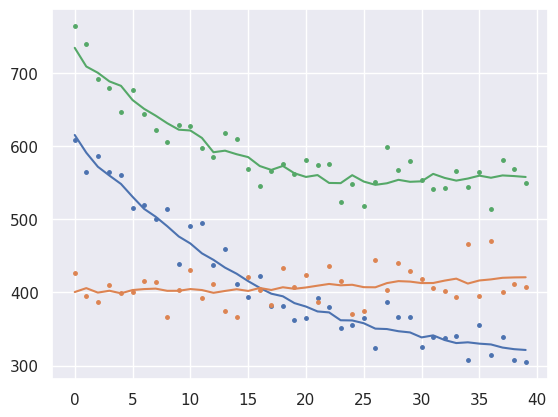

In [27]:
PCA_fit(spectra_data.iloc[:, 190:230], n_components=2)

N,D = 200,500
Using method 2


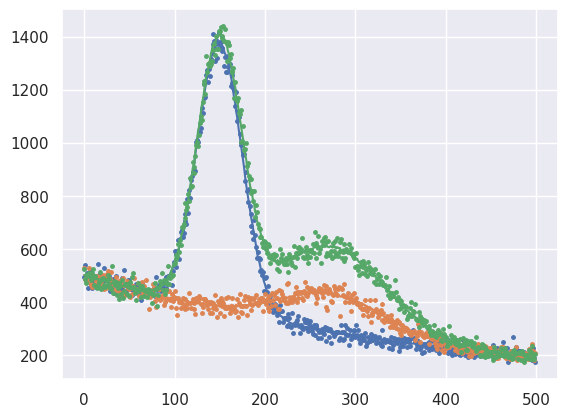

In [28]:
PCA_fit(spectra_data, n_components=2)

N,D = 200,200
Using method 3


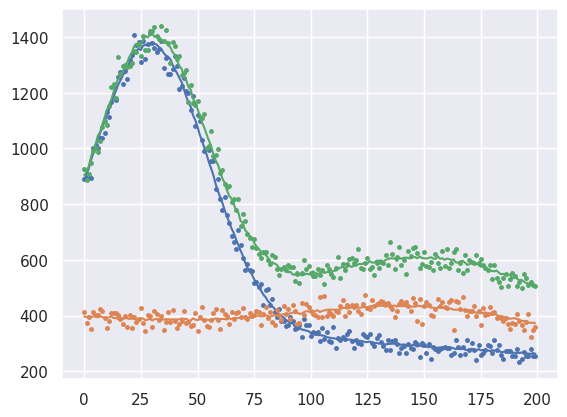

In [29]:
PCA_fit(spectra_data.iloc[:, 120:320], n_components=2)

## <span style="color:Orange">Problem 2</span>

Implement the function below to compare clusters found in a full dataset with those found in a reduced dataset (lower-dimension latent space). Use KMeans for clustering and PCA to obtained the reduced dataset.

In [ ]:
def compare_clusters(data, n_clusters, n_components, seed=123):
    """Compare clusters in the full vs reduced feature space.

    Parameters
    ----------
    data : pandas DataFrame
        Dataset to analyze of shape (N, D).
    n_clusters : int
        Number of clusters to find using KMeans.
    n_components : int
        Number of dimensions of the reduced latent variable space
        to calculate using PCA.
    seed : int
        Random number seed used for reproducible KMeans and PCA.

    Returns
    -------
    tuple
        Tuple (labels1, labels2) of 1D integer arrays of length N,
        with values 0,1,...,(n_clusters-1).
    """
    gen = np.random.RandomState(seed=seed)
    # YOUR CODE HERE
    raise NotImplementedError()

Use the code below to test your function and comment (in the last markdown cell) on how the full vs reduced clusters compare and whether there is an advantage to clustering in reduced dimensions.

In [ ]:
labels1, labels2 = compare_clusters(spectra_data, 4, 2)
fig, ax = plt.subplots(4, 2, figsize=(8, 12))
for i in range(4):
    sel1 = np.where(labels1 == i)[0]
    sel2 = np.where(labels2 == i)[0]
    for j in range(4):
        ax[i, 0].plot(spectra_data.iloc[sel1[j]], 'r.', ms=5)
        ax[i, 1].plot(spectra_data.iloc[sel2[j]], 'b.', ms=5)

Analyzing your results above, comment in the empty markdown cell below on how the full vs reduced clusters compare and whether there is any potential advantage to clustering in reduced dimensions.

<img src="https://raw.githubusercontent.com/illinois-mlp/MachineLearningForPhysics/main/img/AnsStart.svg" width=200 align=left></img><br>

<img src="https://raw.githubusercontent.com/illinois-mlp/MachineLearningForPhysics/main/img/AnsEnd.svg" width=200 align=left></img><br>

## <span style="color:Orange">Acknowledgments</span>

* Initial version: Mark Neubauer

© Copyright 2025